In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN 사용하여 셰익스피어 문체 생성하기

### 데이터 셋 만들기

In [2]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [3]:
#모든 글자를 정수로 인코딩

#텍스트에 사용되는 모든 글자를 찾아 ID를 매핑, ID는 1부터 시작해서 고유한 글자 개수까지

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) #단어 수준 대신에 글자 수준 인코딩, 기본으로 소문자사용
tokenizer.fit_on_texts(shakespeare_text)

In [4]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [5]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [4]:
max_id = len(tokenizer.word_index) #고유한 글자 개수
dataset_size = tokenizer.document_count # 전체 글자 개수

max_id, dataset_size

(39, 1115394)

In [5]:
#전체 텍스트를 인코딩 하여 각 글자를 ID로 나타내기(0-38까지 얻기 위해 1빼기)

#바깥 쪽의 배열 한 차원을 버리기
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

encoded

array([19,  5,  8, ..., 20, 26, 10])

### 순차 데이터셋 나누기

텍스트의 처음 90%를 훈련 세트로 사용

In [6]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### 순차 데이터를 윈도 여러 개로 자르기

훈련세트가 백만개 이상의 글자로 이루어진 시퀀스 하나 이므로 직접 훈련 불가능.

In [8]:
n_steps=100 #RNN은 n_steps보다 긴 패턴 학습 불가. 따라서 너무 줄이면 곤란함

window_length = n_steps + 1 #target = 1글자 앞의 입력

#shift=1을 지정하면 가장 큰 훈련세트 구성 가능(기본 값은 윈도우 크기)
#첫번째 윈도우는 0~100번째 글자, 두번째 윈도우는 1칸 쉬프트 해서 1~101번째 글자
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True) #drop_remainder는 모든 윈도우가 동일하게 101개를 포함하도록

In [10]:
#window는 리스트의 리스트형식의 중첩 데이터셋
#모델을 텐서를 기대하므로 중첩 데이터셋을 플랫 데이터셋으로 변환
dataset = dataset.flat_map(lambda window: window.batch(window_length)) #각 윈도우 마다 batch를 호출해서 텐서 하나를 담은 데이터셋 구성

In [11]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size) #각 윈도를 섞어서 배치 사이즈 만큼 순차적으로 가져오기
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) #각 항목에 대해서 앞의 10자를 입력, 앞의 1자를 제외한 10자를 타겟

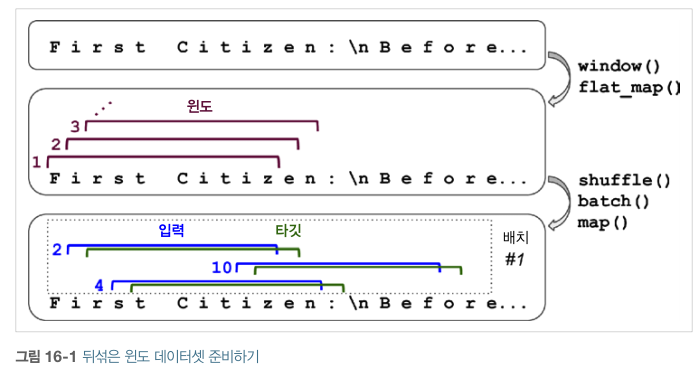

In [12]:
#범주형 특성은 원-핫 벡터나 임베딩으로 인코딩 해야 함
#글자수가 39개이기 때문에 원-핫벡터로 인코딩

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

In [13]:
#프리패치 설정
dataset = dataset.prefetch(10)

In [14]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### Char-RNN 모델 만들고 훈련하기

GPU에서 실행해도 그다지 속도 향상이 없는데. 그 이유는 GRU에 대해 cuDNN에서 recurrent_dropout이 제공되지 않기 때문

https://github.com/tensorflow/tensorflow/issues/40944

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1

950M에서 실행할 때 한 에포크에 27분 40초

2600X + 1080에서 약 한시간 정도 걸리는데, 아마도 프리뷰 버전이라서 인텔 CPU에서 더 좋은 성능이 나오는 듯.

In [ ]:
#이전 글자 100개를 기반으로 다음 글자를 예측
#유닛 128개 GRU층 2개 - 입력(dropout)과 은닉 상태(recurrent_dropout)에 20% 드롭아웃 사용

model = keras.models.Sequential([
#     keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
#                     dropout=0.2, recurrent_dropout=0.2),
#     keras.layers.GRU(128, return_sequences=True,
#                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], 
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2),
#     keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], 
#                      reset_after=True, recurrent_activation='sigmoid',
#                      dropout=0.2),
#     keras.layers.GRU(128, return_sequences=True,
#                      reset_after=True, recurrent_activation='sigmoid',
#                      dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                   activation="softmax")) #39개의 글자 중에서 베타적 확률 계산
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Train for 31370 steps
Epoch 1/10
  808/31370 [..............................] - ETA: 58:40 - loss: 2.2369

이후 가짜 셰익스피어 텍스트 생성은 일단 수행 불가(너무 오래 걸림)

### 상태가 있는 RNN

RNN이 한 훈련 배치를 처리한 후에 마지막 상태를 다음 훈련 배치의 초기 상태로 사용하면?

모델이 장기간 패턴을 학습할 수 있음

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

#상태가 있는 RNN은 각 입력 시퀀스가 이전 배치의 시퀀스가 끝난 지점에서 시작해야 함.
#순차적이고 겹치지 않은 입력 시퀀스를 만들기 위해 shift=1대신에 전체 훈련 스텝 만큼 건너뛰는 윈도우 구성
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1) #각 배치의 시퀀스가 연속적이도록 하기 위해 배치 크기를 1로 설정
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
#전체 데이터를 길이가 동일한 32개의 텍스트로 나누고 각 32개의 텍스트에 대해 연속적인 배치 구성

batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

### 감성 분석

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]

17465344/17464789 [==============================] - 2s 0us/step


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

데이터 셋은 이미 전처리 되어 있음

X_train은 각 리뷰의 리스트.

각 리뷰는 넘파이 정수 배열로 표현

각 정수는 하나의 단어

구두점을 모두 제거, 단어는 소문자로, 공백으로 나누어 빈도에 따라 인덱스(낮은 정수가 자주 등장하는 단어)

0, 1, 2는 각각 패딩 토큰, SOS(start of sequence)토큰, 알 수 없는 단어

In [12]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
    
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

실제로는 직접 전처리해야 함

Tokenizer 클래스를 사용하고 char_level=False를 설정.

단어 인코딩시 대부분의 구두점, 줄바꿈, 탭 등의 글자가 제외됨

### IMDB 데이터셋 원본을 통해 직접 전처리 과정 포함시키기

이미 전처리된 데이터셋 말고 원본을 전처리 과정에 포함시키기

In [14]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

train_size

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAWDLRU/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAWDLRU/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAWDLRU/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


25000

In [15]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300) #각 리뷰에서 첫 300글자만 남기기
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ") #<br />태크 공백으로 변경
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ") #문자와 작은 따옴표가 아닌 모든 문자를 공백으로
    X_batch = tf.strings.split(X_batch) #리뷰를 공백으로 나누기(래그드 텐서)
    
    #래그드 텐서를 밀집 텐서로, 동일한 길이가 되도록 패딩 토큰으로 모든 리뷰 패딩
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch 

In [16]:
#어휘 사전 구축

from collections import Counter

vocab = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocab.update(list(review.numpy()))

In [17]:
#가장 많이 등장하는 단어 세 개
vocab.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [19]:
#사전에 있는 모든 단어를 알아야 할 필요는 없을 테니 가장 많이 등장하는 단어 10000개만 남기기

vocab_size = 10000
truncated_vocab = [
    word for word, count in vocab.most_common()[:vocab_size]
]

truncated_vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'to', b'I', b'is', b'in', b'this']

In [20]:
#각 단어를 ID(어휘 사전의 인덱스)로 바꾼느 전처리 단계 추가.
#out-of-vocabulary 버킷을 사용하는 룩업 테이블 구성

words = tf.constant(truncated_vocab)
word_ids = tf.range(len(truncated_vocab), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [21]:
table.lookup(tf.constant([b"This movie was faaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10862]])>

룩업 테이블에 있는 단어들의 ID는 10000보다 작고, 없는 단어는 10000보다 크거나 같은 ID를 가진 oov버킷 중 하나에 매핑됨

### tf.compute_and_apply_vocabulary() 함수는 데이터셋에서 고유한 단어를 찾아 어휘 사전을 구축

In [25]:
# 최종 훈련 세트 만들기

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [26]:
# 훈련 세트 확인

for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [27]:
embed_size = 128

model = keras.models.Sequential([
    #단어 ID를 임베딩으로 변환, 단어 ID당 하나의 행과 임베딩 차원당 하나의 열
    #입력은 [배치 크기, 타입 스텝 수] -> 임베딩 출력은 [배치 크기, 타임 스텝 수, 임베딩 크기]
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                          mask_zero=True, #ID가 0인 패딩 토큰 무시! -> 패딩 토큰을 항상 0으로 인코딩 하는 것이 좋은 방법
                          input_shape=[None]), 
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch= train_size // 32, epochs = 5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 83s 106ms/step - loss: 0.5426 - accuracy: 0.7155
Epoch 2/5
781/781 [==============================] - 80s 103ms/step - loss: 0.3477 - accuracy: 0.8556
Epoch 3/5
781/781 [==============================] - 82s 105ms/step - loss: 0.1748 - accuracy: 0.9372
Epoch 4/5
781/781 [==============================] - 78s 99ms/step - loss: 0.1279 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 79s 101ms/step - loss: 0.1069 - accuracy: 0.9595


### 사전 훈련된 임베딩 재사용하기

턴서플로우 허브 프로젝트에서 사전 훈련된 모델 컴포넌트(모듈)를 모델에 포함시키기

In [28]:
tf.random.set_seed(42)

TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [30]:
!pip install tensorflow_hub

     |████████████████████████████████| 102kB 248kB/s ta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow_hub as hub

model = keras.Sequential([
    #문장 인코더 - 문자열 입력을 바다 하나의 벡터로 인코딩(50차원)
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", #url의 맨 마지막 부분은 버전
                  dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
             metrics=["accuracy"])

In [33]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001


In [3]:
#IMDb리뷰 데이터셋을 다운로드 하고 전처리 과정 없이 바로 모델 훈련

import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 14s 18ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 13s 17ms/step - loss: 0.5129 - accuracy: 0.7494
Epoch 3/5
781/781 [==============================] - 13s 17ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 14s 17ms/step - loss: 0.5046 - accuracy: 0.7538
Epoch 5/5
781/781 [==============================] - 13s 17ms/step - loss: 0.5017 - accuracy: 0.7561


In [ ]:
test = datasets["test"].take(1)

for X_new, y_new in test:
    y_pred = model.predict(list(X_new.numpy()))
    
    #print(y_pred, y_new)
    


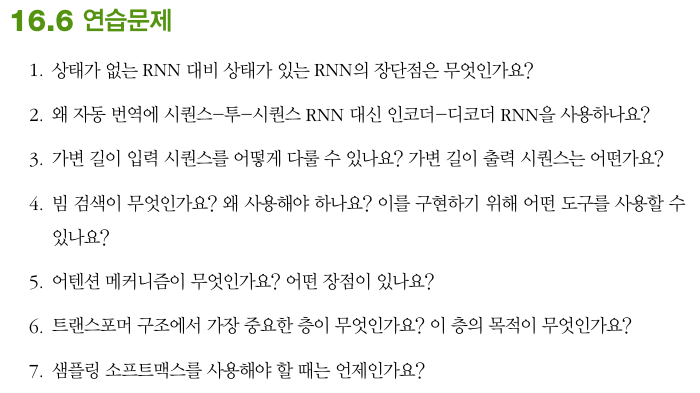

1. 상태가 없는 RNN은 훈련한 윈도우 크기와 같거나 작은 길이의 패턴만 감지  
   상태가 있는 RNN은 장기 패턴을 감지. 하지만 구현하기 어려움
   항상 상태가 있는 RNN이 더 나은 것은 아님.
   
   
2. 문장을 한 번에 단어 하나씩 번역하는 결과가 좋지 않음. 먼저 전체 문장을 읽고나서 변역해야 함  
   시퀀스-투-시퀀스 RNN은 첫 단어를 읽고 바로 문장을 번역하지만, 인코더-디코더 RNN은 전체 문장을 읽고나서 번역 시작
   
   
3. 배치에 있는 모든 시퀀스 길이가 동일하도록 짧은 시퀀스에 패딩을 추가하고 RNN이 패딩을 무시하도록 하여 처리 가능  
   출력 시퀀스의 끝에 EOS(end of sequence)토큰을 출력하도록 모델을 훈련하는 것이 한 방법
   
   
4. 빔 검색은 훈련된 인코더-디코더 모델의 성능을 향상하기 위해 사용하는 기술  
   텐서플로우 애드온을 사용하면 쉽게 구현 가능


5. 디코더가 입력 시퀀스에 직접 접근하여 긴 입력 시퀀스를 처리하기 위한 방법  
   입력의 어느 부분이 현재 디코더의 타임 스탭에 가장 관련되어 있는지 나타내는 정렬 점수 사용
   
   
6. 멀티-헤드 어텐션 층  


7. 클래스가 매우 많은(수천개) 분류 모델을 훈련할 때 사용.   

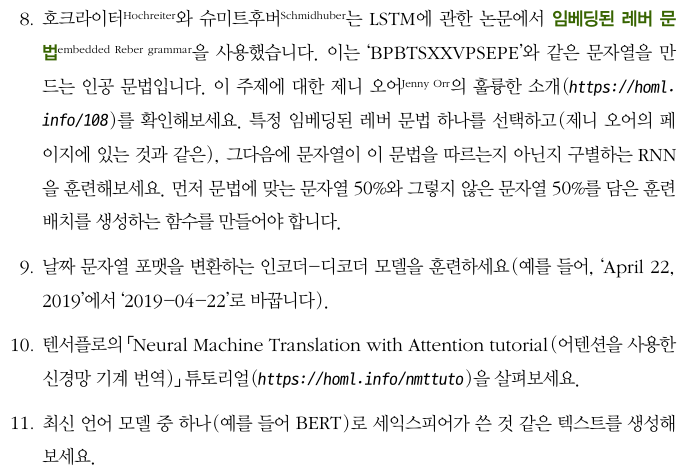

In [2]:
# 연습문제 9

from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal() #1년 1월 1일 부터 누적된 날짜

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [6]:
dt = date(9999, 12, 31)
MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y")

'December 31, 9999'

In [7]:
np.random.seed(42)

n_dates = 3
X_examples, y_examples = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(X_examples[idx], y_examples[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [8]:
#입력에 사용가능한 모든 문자열

INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "0123456789, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy0123456789, '

In [9]:
#출력에 사용가능한 모든 문자열
OUTPUT_CHARS = "0123456789-"

In [10]:
#문자열을 글자의 ID로  변환

def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [11]:
X_examples[0], date_str_to_ids(X_examples[0])

('September 20, 7075',
 [7, 11, 19, 22, 11, 16, 9, 11, 20, 37, 28, 26, 36, 37, 33, 26, 33, 31])

In [13]:
y_examples[0], date_str_to_ids(y_examples[0], OUTPUT_CHARS)

('7075-09-20', [7, 0, 7, 5, 10, 0, 9, 10, 2, 0])

In [19]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(date_str, chars) for date_str in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1) #1차원 래그드 텐서(비정형 텐서)
    return (X + 1).to_tensor() # 0을 패딩 토큰 ID로 사용하기 위해

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [20]:
np.random.seed(42)

X_train, y_train = create_dataset(10000)
X_valid, y_valid = create_dataset(2000)
X_test, y_test = create_dataset(2000)

In [22]:
y_train[0], y_train.shape

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>,
 TensorShape([10000, 10]))

### 첫번째 모델 기본적인 seq2seq 모델

입력 시퀀스를 넣으면 인코더를 통과하고(임베딩 레이어 + LSTM 레이어), 출력으로 나온 벡터를 디코더에 넣고(LSTM 레이어 + Dense) 출력으로 벡터 시퀀스가 나온다. 각 벡터는 모든 가능한 출력 문자열에 대한 확률

디코더가 입력으로 시퀀스를 기대하므로 벡터를 반복해서 사용한다???

In [24]:
embedding_size = 32
max_output_length = y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                          output_dim = embedding_size,
                          input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 27s 3ms/sample - loss: 1.7967 - accuracy: 0.3555 - val_loss: 1.3766 - val_accuracy: 0.4927
Epoch 2/20
10000/10000 [==============================] - 23s 2ms/sample - loss: 1.4687 - accuracy: 0.4735 - val_loss: 1.3322 - val_accuracy: 0.5231
Epoch 3/20
10000/10000 [==============================] - 23s 2ms/sample - loss: 1.2365 - accuracy: 0.5647 - val_loss: 1.0643 - val_accuracy: 0.6184
Epoch 4/20
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.9113 - accuracy: 0.6649 - val_loss: 0.8019 - val_accuracy: 0.6969
Epoch 5/20
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.6638 - accuracy: 0.7442 - val_loss: 0.5712 - val_accuracy: 0.7760
Epoch 6/20
10000/10000 [==============================] - 21s 2ms/sample - loss: 0.6792 - accuracy: 0.7549 - val_loss: 0.4508 - val_accuracy: 0.8249
Epoch 7/20
10000/10000 [==============================] -

In [25]:
#출력으로 받은 문자열 아이디의 시퀀스를 일반 문자열로 변환

def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return [
        "".join(
            [("?" + chars)[index] for index in sequence]
        ) for sequence in ids
    ]

In [26]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [27]:
ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


In [28]:
#모델이 날짜의 길이인 18로 훈련되었으므로, 짧은 시퀀스에 대해서는 예측이 떨어질 수 있다.

X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

ids = model.predict_classes(X_new)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-11-14


In [29]:
#훈련할 때 처럼 항상 같은 길이의 문자열을 넘기도록 설정

max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [30]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

### 두번째 버전 : 쉬프트 시킨 타겟을 디코더에 입력하기(teacher forcing)

단순하게 인코더의 출력 벹러를 반복해서 입력하는 대신에 타겟 시퀀스를 1타입 스탭씩 오른쪽으로 쉬프트하여 입력할 수 있다. 이렇게 하면 디코더는 매번 이전 타겟 문자가 뭔지 알 수 있다.

좀 더 복잡한 seq2seq문제를 해결하는 데 도움이 된다.

각 타켓 시퀀스의 첫 번째 출력 문자열은 이전 문자열이 존재하지 않으므로 sos(start of sequence)문자열을 추가

추론 과정에서 sos부터 시작해서 한 문자열씩 예측하여 디코더에게 현재까지 예측된 모든 문자열을 입력으로 넘겨준다.

In [31]:
#디코더의 입력 만들기

#시퀀스 시작
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(y):
    sos_tokens = tf.fill(dims=(len(y), 1), value=sos_id)
    return tf.concat([sos_tokens, y[:, :-1]], axis=1) #각 타겟 값의 맨 뒤에 sos토큰 추가

X_train_decoder = shifted_output_sequences(y_train)
X_valid_decoder = shifted_output_sequences(y_valid)
X_test_decoder = shifted_output_sequences(y_test)

In [32]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

In [34]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1, #패딩토큰 추가
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2, #sos와 패딩토큰 추가
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 24s 2ms/sample - loss: 1.6936 - accuracy: 0.3647 - val_loss: 1.4542 - val_accuracy: 0.4241
Epoch 2/10
10000/10000 [==============================] - 21s 2ms/sample - loss: 1.2616 - accuracy: 0.5246 - val_loss: 1.0100 - val_accuracy: 0.6277
Epoch 3/10
10000/10000 [==============================] - 21s 2ms/sample - loss: 0.6774 - accuracy: 0.7634 - val_loss: 0.3730 - val_accuracy: 0.8870
Epoch 4/10
10000/10000 [==============================] - 21s 2ms/sample - loss: 0.2236 - accuracy: 0.9459 - val_loss: 0.1254 - val_accuracy: 0.9786
Epoch 5/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0818 - accuracy: 0.9895 - val_loss: 0.0466 - val_accuracy: 0.9973
Epoch 6/10
10000/10000 [==============================] - 21s 2ms/sample - loss: 0.0286 - accuracy: 0.9995 - val_loss: 0.0214 - val_accuracy: 0.9997
Epoch 7/10
10000/10000 [==============================] -

In [35]:
#예측 하려면 한 번에 문자 하나씩 예측 수행

sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs) #입력 값에 패딩을 채우고
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id) #sos로 채워진 예측 값
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [36]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

### TF-Addon 사용하여 seq2seq 구현

두번째 모델과 동일한 모델 만들기

In [38]:
#0.10.0에서 에러가 발생하는 코드가 있으므로
!pip install tensorflow-addons==0.9.1

     |████████████████████████████████| 1.0MB 253kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
import tensorflow_addons as tfa #TF-Addon 사용

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/15
10000/10000 [==============================] - 61s 6ms/sample - loss: 1.6698 - accuracy: 0.3717 - val_loss: 1.4631 - val_accuracy: 0.4196
Epoch 2/15
10000/10000 [==============================] - 57s 6ms/sample - loss: 1.3154 - accuracy: 0.4942 - val_loss: 1.0593 - val_accuracy: 0.6133
Epoch 3/15
10000/10000 [==============================] - 57s 6ms/sample - loss: 0.8292 - accuracy: 0.7037 - val_loss: 0.5684 - val_accuracy: 0.8065
Epoch 4/15
10000/10000 [==============================] - 57s 6ms/sample - loss: 0.3408 - accuracy: 0.8989 - val_loss: 0.1620 - val_accuracy: 0.9719
Epoch 5/15
10000/10000 [==============================] - 58s 6ms/sample - loss: 0.1285 - accuracy: 0.9782 - val_loss: 0.1141 - val_accuracy: 0.9845
Epoch 6/15
10000/10000 [==============================] - 56s 6ms/sample - loss: 0.0455 - accuracy: 0.9978 - val_loss: 0.0298 - val_accuracy: 0.9995
Epoch 7/15
10000/10000 [==============================] -

In [41]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [42]:
#이전에 훈련한 레이어를 사용해서 새로운 디코더 작성
#한 글자씩 예측 하는 대신 간단하게 예측 가능

inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [43]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [44]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

연습문제 10

https://www.tensorflow.org/tutorials/text/nmt_with_attention

확인해보기

### 연습문제 11

요즘의 언어 모델(GPT 같은)을 사용해서 셰익스피어 텍스트 만들어 보기

In [47]:
!pip install transformers

     |████████████████████████████████| 778kB 254kB/s eta 0:00:01
     |████████████████████████████████| 890kB 3.5MB/s eta 0:00:01
     |████████████████████████████████| 665kB 3.6MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 92kB 5.1MB/s eta 0:00:011
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=894091 sha256=440b3b1db981dee88496aa629fffab66312ba2dba43a61e3b5bd27577e0481c0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
You should consider upgrading via the 'pip install --upgrade pip' command.


In [48]:
#트랜스포머 라이브러리에서 모델 로드하여 사용하기.
#BERT, GPT-2 등의 자연어 처리 네트워크와 사전 훈련된 모델 제공

#OpenAI의 GPT 모델 사용
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

All model checkpoint weights were used when initializing TFOpenAIGPTLMHeadModel.

All the weights of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


In [49]:
# 이 모델을 위한 특별 tokenizer 필요함.

from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [50]:
#제시할 문장을 인코딩 하기
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [51]:
#제시할 문장 이후의 텍스트 예측
#5개의 서로 다른 문장 생성

num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239, 40477,   244,   481,  2761,  7994,   587,   595,
         2985,   512,   557,   246,  4815,   239,   481,  2676,   544,
          617,   704,  1377,   239,   244,     8, 24294,   603,   239,
        40477,   244,   249,  1048,  1458,   562,   481, 21200,   240,
          568,   718,   759,   600,   604],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   487,   759,   808,  1777,   485,  1300,   481,
         2873,   498,   507,  1990,   246,  6560, 21467,   240,  1389,
          557, 29616,   239, 29616,   558,   728,  5055,   491,  1279,
          271,   524,  1158,   535,  1163,   240,   524,  7590,   240,
          488,   524, 33651,   498,   517],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   636,   580,   481, 24721,   488,   905,  2589,   520,
          558

In [52]:
#생성된 문장 디코딩

for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle. 
 " the sea folk do not wear you as a princess. the magic is from your blood. " ahab said. 
 " i am sorry for the orcs, but how can they have
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. he can only hope to turn the weight of it towards a worthy adversary, such as claudio. claudio had other matters at heart : his father's home, his territory, and his armada of at
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle would be the richest and most comfortable she had ever come across. 
 her lady's guards stopped the marching and bowing, held the queen's hand. 
 " lady - king decanus is a
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, he was it. but he was sure that if he gave up his mortal form for the fu